# Full regional extraction
Here we will extract cells from a variable size continuous polygon.
This will be the first step in doing a full regionalising model.

In [1]:
#Loading things as usual
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Ok, the approach will be this
1. Let $p=(x,y)$ in Mexico
2. Create a buffer size list (maybe exponential) not to big.
4. Generate a list of polygons according to this list.
5. Overlay with the mesh (lowest resolution)
6. Extract cells, or cell ids.


In [59]:
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
newp = p.buffer(0.08)
np.linspace(0.03,1, 10)
polys = map(lambda r : p.buffer(r),radii)


In [63]:
## Intersect the polygons with the cells to obtain the targets

In [64]:
from mesh.models import initMesh

In [66]:
mexmesh = initMesh(11)

DEBUG Changed MESH TABLE SPACE


In [70]:
intersected_cells = map(lambda poly : mexmesh.objects.filter(cell__intersects=poly),polys)

In [84]:
# Number of selected cells in each buffer
values = map(lambda l : list(l.values_list('id',flat=True)),intersected_cells)

In [97]:
## Change to network database
from traversals.strategies import idsToCells
cells = map(lambda level : list(idsToCells(level)),values)

INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database
INFO Compiling Query and asking the Graph Database


In [99]:
### Sumon the LToL
# Following example from Data generator
from drivers.tree_builder import buildTreeNeo
trees = []
for list_of_cells in cells:
    %time trees.append(map(lambda c : buildTreeNeo(c),list_of_cells))


CPU times: user 1min 49s, sys: 3.46 s, total: 1min 52s
Wall time: 2min 26s
CPU times: user 2min 31s, sys: 4.3 s, total: 2min 35s
Wall time: 3min 8s
CPU times: user 4min 32s, sys: 7.92 s, total: 4min 40s
Wall time: 5min 42s
CPU times: user 6min 29s, sys: 11.4 s, total: 6min 40s
Wall time: 7min 45s
CPU times: user 9min 14s, sys: 16.5 s, total: 9min 30s
Wall time: 10min 45s
CPU times: user 10min 25s, sys: 18 s, total: 10min 43s
Wall time: 12min 6s
CPU times: user 10min 53s, sys: 18.8 s, total: 11min 12s
Wall time: 12min 38s
CPU times: user 13min 13s, sys: 22.2 s, total: 13min 35s
Wall time: 15min 14s
CPU times: user 13min 46s, sys: 24.3 s, total: 14min 10s
Wall time: 15min 51s
CPU times: user 14min 31s, sys: 25.1 s, total: 14min 56s
Wall time: 16min 45s


In [109]:
## Pseudo Presence bursea 
from traversals import strategies as st
## Get all models, environmental variables
from raster_api.models import raster_models_dic

In [110]:
rstmods = raster_models_dic.keys()

In [111]:
%time data = map(lambda cell : st.getEnvironmentalCovariatesFromListOfCells(cell,vars=rstmods),cells)

CPU times: user 2min 54s, sys: 2.78 s, total: 2min 57s
Wall time: 39min 38s


In [112]:
data[0]

,DistanceToRoadMex_mean,Elevation_mean,MaxTemperature_mean,MeanTemperature_mean,MinTemperature_mean,Precipitation_mean,SolarRadiation_mean,Vapor_mean,WindSpeed_mean,WorldPopLatam2010_mean,Longitude,Latitude
0,1609.861499,2239.222222,24.643981,18.560185,24.710648,107.967593,17679.243056,1.159722,2.032407,8.735614,-99.807563,17.59639
1,6233.812910,1652.777778,27.154630,20.932870,27.212963,96.173611,17843.750000,1.418981,1.907407,6.919019,-99.807563,17.54739
2,10087.688906,2358.555556,24.201389,17.613426,24.273148,110.537037,17691.506944,1.074074,2.034722,95.356859,-99.660563,17.54739
3,12710.321797,1488.222222,28.201157,21.719907,28.254630,89.300926,17911.456019,1.567130,1.842593,14.527805,-99.709563,17.49839
4,2652.417666,1677.777778,28.345556,21.861111,28.413889,84.711111,17996.188889,1.497222,1.844444,38.535857,-99.758563,17.64539
5,2225.987627,1999.888889,26.986343,20.655093,27.037037,93.701389,17908.340278,1.381944,1.918981,27.140912,-99.758563,17.59639
6,5848.897832,1864.555556,25.928704,19.847222,25.979167,103.506944,17779.129630,1.289352,1.960648,8.222610,-99.856563,17.54739
7,10942.985898,1455.444444,28.662963,22.356481,28.712963,87.034722,18044.143519,1.636574,1.814815,27.206239,-99.758563,17.49839
8,1244.787793,1537.222222,29.821111,23.036111,29.866667,76.963889,18070.966667,1.597222,1.741667,120.900373,-99.709563,17.64539
9,8462.351133,1116.555556,30.212269,23.611111,30.266204,101.300926,18215.988426,1.895833,1.717593,37.159275,-99.807563,17.49839


## Let's build the Pseudo presence absence
First, Let be bursera the node we want to model

In [113]:
bursera = pickNode(Family,'Burseracea')

In [361]:
root_node = bursera.getParent().getParent().getParent().getParent().getParent()

In [120]:
t = trees[0][0]

In [3]:
presences = []
for ltree in trees:
    %time presences.append(st.getPresencesForNode(root_node,ltree))
    

NameError: name 'trees' is not defined

In [363]:

from ecoregions.models import TerrEcoregions,InegiIV

In [364]:
%%time
def extractVegetation(list_points):
    """
    Given a list of points it will return a dataframe of the corresponding vegetation 
    type from the TerrEcoregions and INEGI series V.
    To be included in data extraction method, but there's no time for it, there's never time for anything!
    Returns a dataframe.
    """
    points = list_points
    ecoregions = map(lambda p : TerrEcoregions.objects.filter(geom__intersects=p),points)
    ecovalues = map(lambda q : q.values_list('wwf_mhtnum','wwf_mhtnam'),ecoregions)
    inegiregions = map(lambda p : InegiIV.objects.filter(geom__intersects=p),points)
    inegivalues = map(lambda q : q.values_list('covid','name'),inegiregions)
    ecovals = [r.get() if r.exists() else (np.nan,'NaN') for r in ecovalues ]
    inegivals = [r.get() if r.exists() else (np.nan,'NaN') for r in inegivalues ]
    # Compile dataframe
    vegdat = pd.DataFrame(ecovals)
    inegidat = pd.DataFrame(inegivals)
    vegdat.columns = ['vegid','vegname']
    inegidat.columns = ['inegiv5id','inegiv5name']
    results = pd.concat([vegdat,inegidat],axis=1)
    return results

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.9 µs


In [365]:
centers_nested = map(lambda c : map(lambda p : p.centroid, c),cells)

In [366]:
## Calculate tipo de vegetacion
vegie_types = map(lambda lp : extractVegetation(lp),centers_nested)

In [367]:

vegie_types[0][:2]

,vegid,vegname,inegiv5id,inegiv5name
0,3,Tropical and Subtropical Coniferous Forests,93588,VEGETACIÓN SECUNDARIA ARBÓREA DE BOSQUE DE PIN...
1,3,Tropical and Subtropical Coniferous Forests,91982,VEGETACIÓN SECUNDARIA ARBUSTIVA DE BOSQUE DE P...


In [368]:
datos = zip(presences,data,vegie_types)

In [369]:
## Compile the dataframe and convert to geopandas
dd = map(lambda (p,d,v) : pd.concat([p,d,v],axis=1),datos)
dd = map(lambda d : st.toGeoDataFrame(d,xcoord_name='Longitude',ycoord_name='Latitude'),dd)

In [370]:
## Maybe this was not necessary
def encode_df(df):
    df['inegiv5name'] = df['inegiv5name'].apply(lambda x: x.decode('utf8'))
    return df

dataframes = map(encode_df,dd)

UnicodeEncodeError: 'ascii' codec can't encode character u'\xd3' in position 8: ordinal not in range(128)

In [371]:
for i,d in enumerate(dataframes):
    cad = '/outputs/presence_only_models/data/root/%s.csv'%i
    print(cad)
    d.to_csv(cad,encoding='utf8')

/outputs/presence_only_models/data/root0.csv
/outputs/presence_only_models/data/root1.csv
/outputs/presence_only_models/data/root2.csv
/outputs/presence_only_models/data/root3.csv
/outputs/presence_only_models/data/root4.csv
/outputs/presence_only_models/data/root5.csv
/outputs/presence_only_models/data/root6.csv
/outputs/presence_only_models/data/root7.csv
/outputs/presence_only_models/data/root8.csv
/outputs/presence_only_models/data/root9.csv


In [372]:
d9 = dd[9]

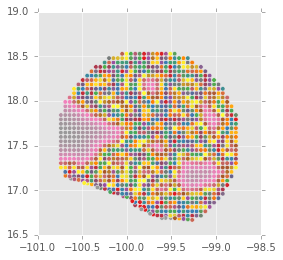

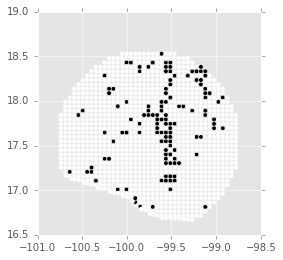

In [158]:
plt.scatter()
dd[9].plot(column='DistanceToRoadMex_mean')
dd[9].plot(column='Burseraceae',cmap=plt.cm.Greys)

In [205]:
otro = d.replace('NaN',np.nan)

In [206]:
otro2 = otro.replace('N.A.',np.nan)

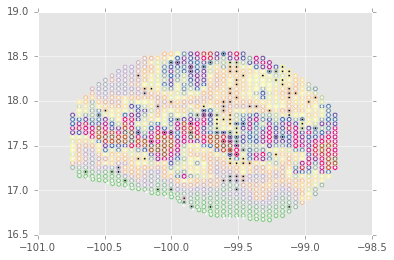

In [227]:
plt.scatter(otro2.Longitude,otro2.Latitude,c=otro2.Elevation_mean,cmap=plt.cm.Accent,s=30)
#plt.scatter(otro2.Longitude,otro2.Latitude,c=otro2.Precipitation_mean,cmap=plt.cm.Accent,s=30)

#plt.scatter(otro2.Longitude,otro2.Latitude,c=otro2.DistanceToRoadMex_mean,cmap=plt.cm.Accent,s=30)
plt.scatter(otro2.Longitude,otro2.Latitude,c=otro2.Burseraceae,cmap=plt.cm.Greys,s=5,vmin=0.5,vmax=1.0)

In [310]:
d9.columns

Index([           u'Burseraceae', u'DistanceToRoadMex_mean',
               u'Elevation_mean',    u'MaxTemperature_mean',
         u'MeanTemperature_mean',    u'MinTemperature_mean',
           u'Precipitation_mean',    u'SolarRadiation_mean',
                   u'Vapor_mean',         u'WindSpeed_mean',
       u'WorldPopLatam2010_mean',              u'Longitude',
                     u'Latitude',               u'geometry'],
      dtype='object')

In [60]:
## This is for plotting the polygons
from geopandas import GeoSeries,GeoDataFrame
from shapely.wkt import loads

load = map(lambda p : loads(p.wkt),polys)
#s = GeoDataFrame(GeoSeries(load))
